Бербер Кирилл,, 317 группа

# 2 практическое задание. Сегментация изображений. # 
## Практикум на ЭВМ для 317 группы, весна 2021 ##

**Фамилия, имя: Бербер Кирилл**

Дата выдачи: 18 марта 00:00|

Мягкий дедлайн: 1 апреля 23:59

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet.

Ссылка на данные: https://yadi.sk/d/-ug82uwhSuLYrA

### Загрузка данных (1 балл) ###
Для загрузки данных pytorch опирается на такую сущность, как Dataset.

Этот абстрактный класс определен в torch.utils.data.dataset:

In [1]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — torchvision.datasets.ImageFolder, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (./train/{class} и ./val/{class}):

imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [2]:
!pip install torch

In [3]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

In [4]:
torch.cuda.is_available()

True

In [5]:
a = torch.ones(5)
print(a)
b = a.numpy()
print(b)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]


In [6]:
import os

In [7]:
import torchvision as tv

In [8]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        self.img_mas = []
        self.mask_mas = []
        mas_im = os.listdir(images_dir)
        mas_im = np.sort(mas_im)
        print(mas_im[0:10])
        mas_mask = os.listdir(target_dir)
       
        mas_mask = np.sort(mas_mask)
        print(mas_mask[0:10])
        l = len(mas_im)
        self.ll = l
        check = 0
        while check < l:
            if(check % 200 == 0):
              print("photodataset", check, l)
            im = Image.open(self.images_dir + mas_im[check]).convert('RGB')
            mask = Image.open(self.target_dir + mas_mask[check])
            if self.transforms != None:
                im, mask = self.transforms[0](im, mask)
                im, mask = self.transforms[1](im, mask)
                im = self.transforms[2](im)
                if check > 0:
                    #print(check)
                    im  = self.transforms[3](im, mask, self.img_mas)
           
            self.img_mas +=[im]
            self.mask_mas +=[mask]
            check += 1
        transform_tenz  = tv.transforms.ToTensor() 
        transform_norm =  tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        check = 0
        while check < l:
        #print("im", type(im))
            if(check % 200 == 0):
              print("photodataset circ2", check, l)
            k = transform_tenz(self.img_mas[check])
            self.img_mas[check] = transform_norm(k)
            self.mask_mas[check] = transform_tenz(self.mask_mas[check])
            check += 1
            
    def __len__(self):
        # your code here
        return self.ll
    
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        #ath, target = self.samples[index]
        #sample = self.loader(path)
        #if self.transform is not None:
        #    sample = self.transform(sample)
        #if self.target_transform is not None:
        #    target = self.target_transform(target)

        return  self.img_mas[idx], self.mask_mas[idx]

## Модуль аугментации (3 балла) ##
Конструктор стандартного ImageFolder, принимают параметр transform (и иногда target_transform).

Они служат для того, чтобы загружаемые изображения (обычно это PIL.Image) или таргеты преобразовывать в тензоры нужного вида.

В torchvision входит модуль transforms для стандартных примеров таких преобразований. В transforms могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

In [9]:
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.


В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров. Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:

* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [10]:
from PIL import Image

In [11]:
from PIL import Image, ImageEnhance

In [12]:
def random_flip(img, mask, p = 0.4):
    check = np.random.sample()
    if check < p:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
    return img, mask
def random_crop(img, mask, p = 0.2):
    width, height = img.size
    check = np.random.sample()
    if check < p:
        left = (np.random.sample() / 2) * width
        right = (np.random.sample() / 2 + 0.5) * width
        top = (np.random.sample() / 2) * height
        bot = (np.random.sample() / 2 + 0.5) * height
        img = img.crop((left, top, right, bot))
        mask = mask.crop((left, top, right, bot))
        img = img.resize((width, height), Image.ANTIALIAS)
        mask = mask.resize((width, height), Image.ANTIALIAS)
    return img, mask
#def random_light(img, p = 0.9):
#    check = np.random.sample()
#    print(check)
#    if check < p:
#        brightness = 1 + np.random.sample()
#        for x in range(img.size[0]):
#            for y in range(img.size[1]):
#                r, g, b = img.getpixel((x, y))
#
#                red = int(r * brightness)
#                red = min(255, max(0, red))
#
#                green = int(g * brightness)
#                green = min(255, max(0, green))
#
#                blue = int(b * brightness)
#                blue = min(255, max(0, blue))
#
#        img = img.putpixel((x, y), (red, green, blue))
#    return img
def random_light(img, p = 0.4):
    check = np.random.sample()
    if check < p:
        brightness = 1 + np.random.sample()
        img_brightness_obj=ImageEnhance.Brightness(img)
        enhanced_img = img_brightness_obj.enhance(brightness)
        return enhanced_img
    else:
        return img

def random_fon(img, mask, fons, p = 0.4):
    check = np.random.sample()
    if check < p:
        l = len(fons)
        n = np.random.randint(0, l, 1)[0]
        #print('ok')
        img = Image.composite(img, fons[n], mask)
    return img

In [13]:
np.random.sample()

0.9194840381586225

In [14]:
x = np.random.randint(0, 3, 10)
x

array([1, 1, 0, 2, 0, 0, 2, 2, 0, 1])

In [15]:
#from IPython.display import Image
#img = Image("memes_for_old.jpg")
#img

In [16]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   39G   30G  57% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   40G   35G  54% /opt/bin
tmpfs           6.4G   24K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [17]:
from google.colab import drive

In [18]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [19]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   39G   30G  57% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   40G   35G  54% /opt/bin
tmpfs           6.4G   24K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   14G  1.2G  93% /content/gdrive


In [20]:
!ls /content/gdrive/

MyDrive


In [21]:
!ls /content/gdrive/"MyDrive"/"Colab Notebooks"/"people_data"/"train"/"1.jpg"

'/content/gdrive/MyDrive/Colab Notebooks/people_data/train/1.jpg'


In [72]:
im = Image.open("/content/gdrive/MyDrive/Colab Notebooks/people_data/train/1.jpg").convert('RGB')

In [73]:
#im = Image.open(r"C:\Users\User\Jupiter_notebook\people_data\train/1.jpg").convert('RGB')
#mask = Image.open(r"C:\Users\User\Jupiter_notebook\people_data\train_mask/1.png")
#fons = Image.open(r"C:\Users\User\Jupiter_notebook\people_data\train/4.jpg").convert('RGB')


In [74]:
res = random_light(im)
res.show()
res.size

(240, 320)

In [75]:
#res = random_fon(im, mask, (fons, im))
#res.show()
#res.size

In [76]:
#res = random_crop(im, mask)[0]
#res.show()
#res.size

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

transforms.ToTensor()

transforms.Normalize(mean=[0.485, 0.456, 0.406],

                     std=[0.229, 0.224, 0.225])

In [25]:
#DATA_PATH = r"C:\Users\User\Jupiter_notebook\people_data/"
DATA_PATH = "/content/gdrive/MyDrive/Colab Notebooks/people_data/"
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= (random_flip, random_crop, random_light, random_fon)
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms = None
)

['1.jpg' '10.jpg' '100.jpg' '1000.jpg' '1001.jpg' '1002.jpg' '1003.jpg'
 '1004.jpg' '1005.jpg' '1006.jpg']
['1.png' '10.png' '100.png' '1000.png' '1001.png' '1002.png' '1003.png'
 '1004.png' '1005.png' '1006.png']
photodataset 0 1350
photodataset 200 1350
photodataset 400 1350
photodataset 600 1350
photodataset 800 1350
photodataset 1000 1350
photodataset 1200 1350
photodataset circ2 0 1350
photodataset circ2 200 1350
photodataset circ2 400 1350
photodataset circ2 600 1350
photodataset circ2 800 1350
photodataset circ2 1000 1350
photodataset circ2 1200 1350
['1351.jpg' '1352.jpg' '1353.jpg' '1354.jpg' '1355.jpg' '1356.jpg'
 '1357.jpg' '1358.jpg' '1359.jpg' '1360.jpg']
['1351.png' '1352.png' '1353.png' '1354.png' '1355.png' '1356.png'
 '1357.png' '1358.png' '1359.png' '1360.png']
photodataset 0 141
photodataset circ2 0 141


In [26]:
train_dataset.__getitem__(5)

(tensor([[[ 2.2318,  2.2318,  2.2147,  ..., -1.1589, -1.1418, -1.1247],
          [ 2.2318,  2.2318,  2.2147,  ..., -1.1589, -1.1589, -1.1247],
          [ 2.2318,  2.2318,  2.2147,  ..., -1.1760, -1.1760, -1.1418],
          ...,
          [ 2.1975,  2.1975,  2.1975,  ...,  0.2453,  0.2111,  0.2111],
          [ 2.1804,  2.1975,  2.1975,  ...,  0.2453,  0.1939,  0.1939],
          [ 2.1804,  2.1804,  2.1804,  ...,  0.2282,  0.1939,  0.1768]],
 
         [[ 1.4132,  1.3957,  1.3606,  ..., -1.8431, -1.8431, -1.8256],
          [ 1.4132,  1.3957,  1.3606,  ..., -1.8431, -1.8431, -1.8256],
          [ 1.4307,  1.4132,  1.3782,  ..., -1.8606, -1.8606, -1.8431],
          ...,
          [ 0.7829,  0.7829,  0.7829,  ..., -0.8803, -0.9153, -0.9153],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.8803, -0.9328, -0.9328],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.8978, -0.9328, -0.9503]],
 
         [[ 0.9494,  0.9319,  0.8971,  ..., -1.7522, -1.7347, -1.7347],
          [ 0.9494,  0.9319,

In [27]:
train_dataset[5]

(tensor([[[ 2.2318,  2.2318,  2.2147,  ..., -1.1589, -1.1418, -1.1247],
          [ 2.2318,  2.2318,  2.2147,  ..., -1.1589, -1.1589, -1.1247],
          [ 2.2318,  2.2318,  2.2147,  ..., -1.1760, -1.1760, -1.1418],
          ...,
          [ 2.1975,  2.1975,  2.1975,  ...,  0.2453,  0.2111,  0.2111],
          [ 2.1804,  2.1975,  2.1975,  ...,  0.2453,  0.1939,  0.1939],
          [ 2.1804,  2.1804,  2.1804,  ...,  0.2282,  0.1939,  0.1768]],
 
         [[ 1.4132,  1.3957,  1.3606,  ..., -1.8431, -1.8431, -1.8256],
          [ 1.4132,  1.3957,  1.3606,  ..., -1.8431, -1.8431, -1.8256],
          [ 1.4307,  1.4132,  1.3782,  ..., -1.8606, -1.8606, -1.8431],
          ...,
          [ 0.7829,  0.7829,  0.7829,  ..., -0.8803, -0.9153, -0.9153],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.8803, -0.9328, -0.9328],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.8978, -0.9328, -0.9503]],
 
         [[ 0.9494,  0.9319,  0.8971,  ..., -1.7522, -1.7347, -1.7347],
          [ 0.9494,  0.9319,

In [89]:
#train_dataset.__getitem__(1)[1].show()

Функция для отображения изображения:

In [28]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.



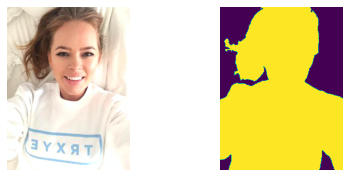

In [303]:
show_idx_image(train_dataset, 0)

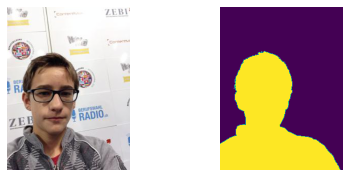

In [307]:
show_idx_image(test_dataset, 3)

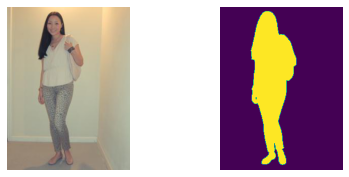

In [29]:
show_idx_image(train_dataset, 8)

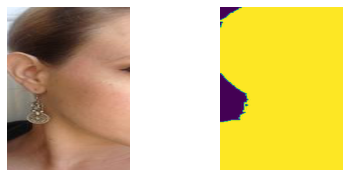

In [ ]:
show_idx_image(train_dataset, 2)

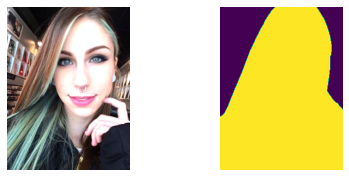

In [30]:
show_idx_image(train_dataset, 4)

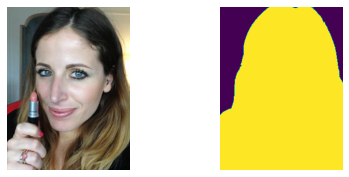

In [31]:
show_idx_image(test_dataset, 4)

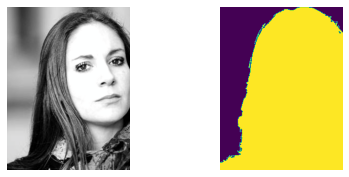

In [ ]:
show_idx_image(test_dataset, 8)


## Загрузчики ##
При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [32]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

In [114]:
#a, b = train_data_loader

## DiceLoss (1 балл) ##
Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$
где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [230]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        chisl = 2 * (logits * true_labels).sum(axis = 2).sum(axis = 1)
        znam = (logits + true_labels + self.eps).sum(axis = 2).sum(axis = 1)
        Diseloss = 1 - chisl / znam
        
        
        if self.reduction == 'sum':
            loss_value = Diseloss.sum()
        elif self.reduction == 'mean':
            loss_value = Diseloss.mean()
        elif self.reduction is None:
            loss_value = Diseloss
            
        return loss_value

Проверка реализации:

In [34]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)## 

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [35]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations


Декодер:

In [36]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [37]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:



In [38]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [39]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = []
    total = 0.
    check = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            #correct += float(val_criterion(outputs, labels).detach())
            correct.append(float(val_criterion(outputs, labels).detach()))
            #print('correct_test', correct)
    
    mean_loss = loss / total
    metric = np.array(correct).mean()
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами).

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [43]:

#VG13 = VGG13Encoder()
model = UNet()
if torch.cuda.is_available():
    model.cuda()


Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


In [44]:
batch_size = 8
lr = 1e-5
weight_decay = 1e-4

In [45]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [40]:
def val_criterion(outputs, labels):
    mask = torch.sigmoid(outputs) > 0.5
    check = torch.zeros_like(outputs)
    check[mask] = 1
    s = torch.sum(check[check == labels])
    summ_tenz = check + labels
    znam = torch.sum(summ_tenz >= 1)
    return s / znam

In [380]:
a = torch.randn(3, 3)
m = torch.sigmoid(a) > 0.6
t = torch.sigmoid(a) > 0.4
print(m)
print(t)
c = torch.zeros_like(a)
d = torch.zeros_like(a)
c[m] = 1 
d[t] = 1
print(c)
print(d)
s = torch.sum(c[c == d])
print(s)
k = torch.sum((c + d) >= 1)
print(c+d)
print(k)
print(s / k)

tensor([[ True, False, False],
        [False,  True, False],
        [ True, False, False]])
tensor([[ True, False,  True],
        [ True,  True, False],
        [ True,  True, False]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])
tensor([[1., 0., 1.],
        [1., 1., 0.],
        [1., 1., 0.]])
tensor(3.)
tensor([[2., 0., 1.],
        [1., 2., 0.],
        [2., 1., 0.]])
tensor(6)
tensor(0.5000)


In [41]:
from tqdm.notebook import tqdm
def train(model, criterion, val_criterion, optimizer, train_data_loader, test_data_loader, num_epoch, device = 'cpu'):
    test_loss = []
    train_loss = []
    test_quality = []
    train_quality = []
    for epoch in tqdm(range(num_epoch)):
        model.train()
        loss_circ = 0
        correct = []
        total = 0
        flag = 0
        for img, labels in tqdm(train_data_loader):
            #img, labels = data
            labels = labels.to(device)
            img = img.to(device)
            optimizer.zero_grad()
            outputs = model(img).to(device)#.to('cpu').view(-1, 320, 240)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total += labels.size(0)
            loss_circ += float(loss.detach())
            per = float(val_criterion(outputs, labels).detach())
            correct.append(per)
            #if flag % 20 == 0:
            # print('train ',per)
            flag += 1
            
        eval_loss, eval_quality = evaluate_net(model, test_data_loader, criterion, val_criterion, device)
        loss_train = loss_circ / total
        qual_train = np.array(correct).mean()
        
        test_loss.append(eval_loss)
        test_quality.append(eval_quality)
        train_loss.append(loss_train)
        train_quality.append(qual_train)
    result = [test_loss, train_loss, test_quality, train_quality]
    return model, result

In [382]:
#train(model, criterion, val_criterion, optimizer, train_data_loader, test_data_loader, 1)

In [47]:
import time
start_time = time.time()
BCEWithLogitsLoss_train = train(model, criterion, val_criterion, optimizer, train_data_loader, test_data_loader, 10, device)
BCEWithLogitsLoss_time = time.time() - start_time

In [48]:
BCEWithLogitsLoss_time

1042.7058548927307

**возможно, многое зависит от времени запуска кода, потому что один и тот же фрагмент сегодня и вчера работал существенно разное время, хотя методы относительно друг друга работают пропорциональное время**

In [401]:
#BCEWithLogitsLoss_train[1]

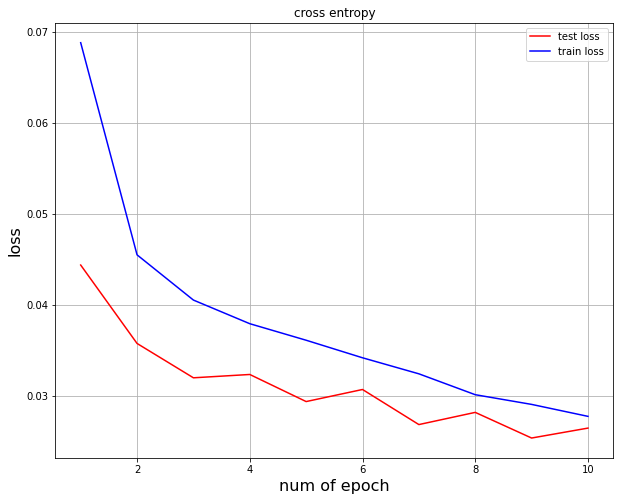

In [49]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][0], color = 'r', label = 'test loss')
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][1], color = 'b', label = 'train loss')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('cross entropy')
plt.show()

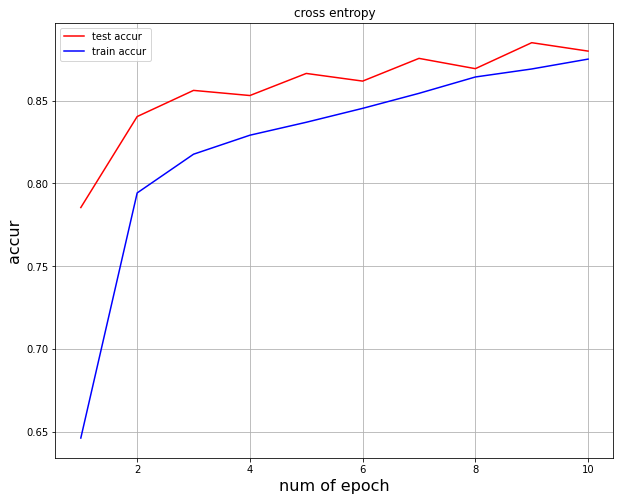

In [50]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][2], color = 'r', label = 'test accur')
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][3], color = 'b', label = 'train accur')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('cross entropy')
plt.show()

In [111]:
#VG13 = VGG13Encoder()
model = UNet()
if torch.cuda.is_available():
    model.cuda()
criterion_2 = DiceLoss(reduction='mean')
optimizer2 = torch.optim.Adam(model.parameters(), lr = lr)

In [112]:
start_time = time.time()
DiceLoss_train = train(model, criterion_2, val_criterion, optimizer2, train_data_loader, test_data_loader, 10, device)
DiceLoss_time = time.time() - start_time

In [113]:
DiceLoss_time

1037.8267583847046

In [114]:
#DiceLoss_train[1]

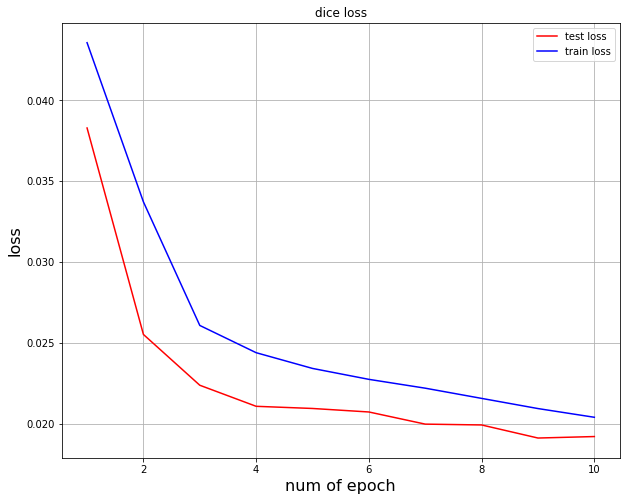

In [115]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_train[1][0], color = 'r', label = 'test loss')
ax.plot(epoch_n, DiceLoss_train[1][1], color = 'b', label = 'train loss')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('dice loss')
plt.show()

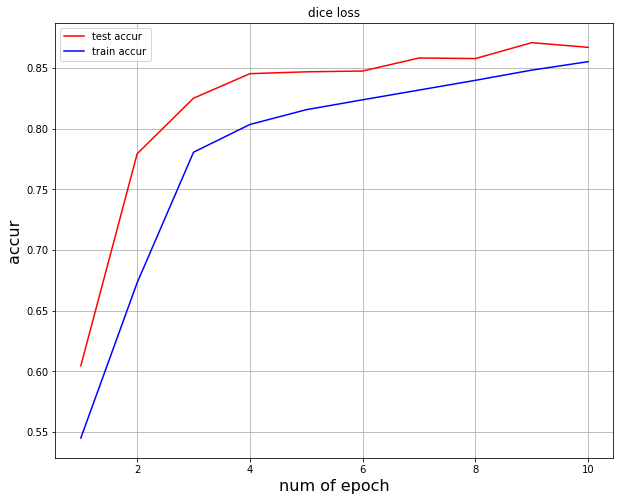

In [116]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_train[1][2], color = 'r', label = 'test accur')
ax.plot(epoch_n, DiceLoss_train[1][3], color = 'b', label = 'train accur')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('dice loss')
plt.show()

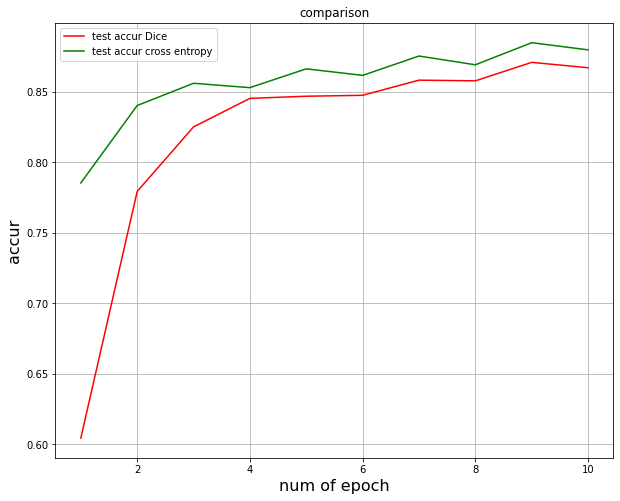

In [117]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_train[1][2], color = 'r', label = 'test accur Dice')
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][2], color = 'g', label = 'test accur cross entropy')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison')
plt.show()

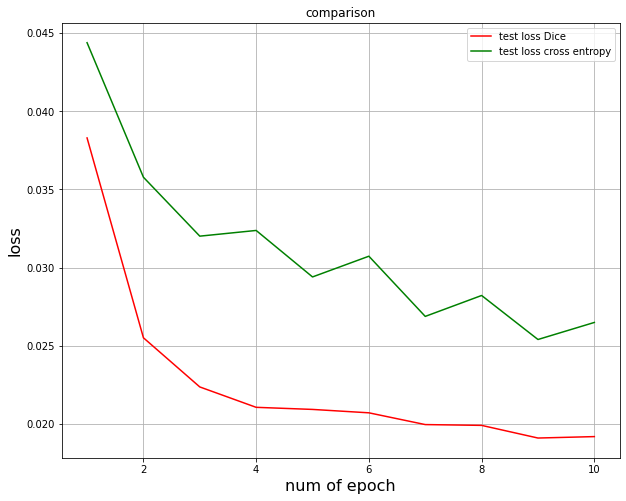

In [118]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_train[1][0], color = 'r', label = 'test loss Dice')
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][0], color = 'g', label = 'test loss cross entropy')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison')
plt.show()

In [235]:
class SummLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        self.first_class = torch.nn.BCEWithLogitsLoss() 
        self.second_class = DiceLoss(reduction='mean') 
        
    def forward(self, logits, true_labels):
        return self.first_class.forward(logits, true_labels) * 0.4 + self.second_class.forward(logits, true_labels) * 0.6

In [236]:
model = UNet()
if torch.cuda.is_available():
    model.cuda()
#criterion = torch.nn.BCEWithLogitsLoss()   
#criterion_2 = DiceLoss(reduction='mean')
criterion_3 = SummLoss()
optimizer3 = torch.optim.Adam(model.parameters(), lr = lr)

In [237]:
start_time = time.time()
Mix_train = train(model, criterion_3, val_criterion, optimizer3, train_data_loader, test_data_loader, 10, device)
Mix_time = time.time() - start_time

In [238]:
Mix_time

1070.927824497223

In [ ]:
#Mix_train[1]

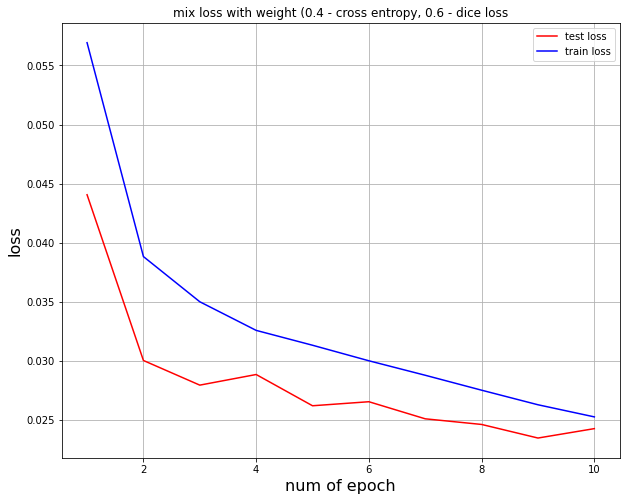

In [239]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, Mix_train[1][0], color = 'r', label = 'test loss')
ax.plot(epoch_n, Mix_train[1][1], color = 'b', label = 'train loss')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('mix loss with weight (0.4 - cross entropy, 0.6 - dice loss')
plt.show()

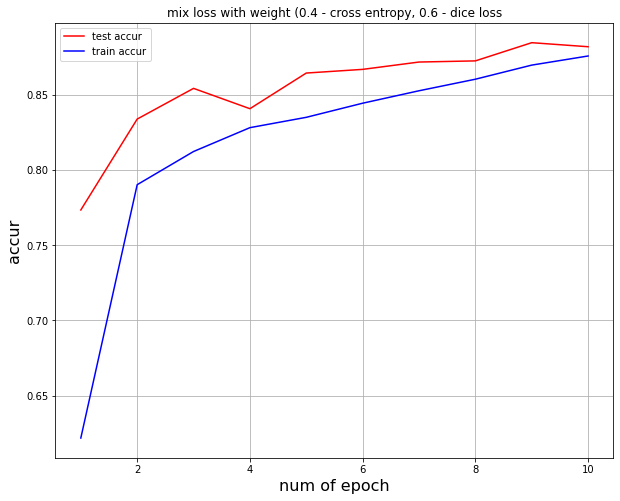

In [241]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, Mix_train[1][2], color = 'r', label = 'test accur')
ax.plot(epoch_n, Mix_train[1][3], color = 'b', label = 'train accur')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('mix loss with weight (0.4 - cross entropy, 0.6 - dice loss')
plt.show()

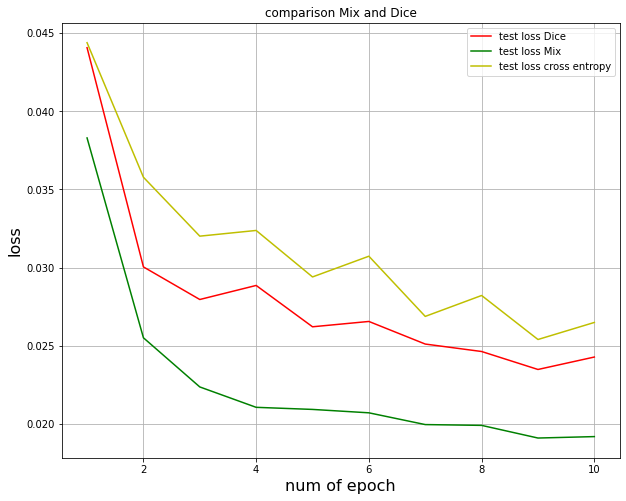

In [244]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, Mix_train[1][0], color = 'r', label = 'test loss Dice')
ax.plot(epoch_n, DiceLoss_train[1][0], color = 'g', label = 'test loss Mix')
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][0], color = 'y', label = 'test loss cross entropy')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison Mix and Dice')
plt.show()

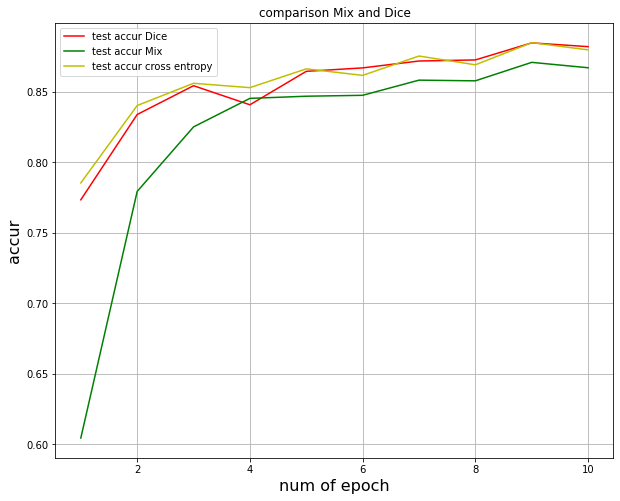

In [245]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, Mix_train[1][2], color = 'r', label = 'test accur Dice')
ax.plot(epoch_n, DiceLoss_train[1][2], color = 'g', label = 'test accur Mix')
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][2], color = 'y', label = 'test accur cross entropy')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison Mix and Dice')
plt.show()

Видно, что при смеси с весами loss уменьшился, показатели accuracy близкие к работе моделей по отдельности, время работы так же существенно не отличается

**Выведем несколько фотографий и масок**

In [89]:
def show_idx_image_after_train(net, test_data_loader, dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    image_to_show_pred = mask_img[0]
    mask_pred = mask_img[0].unsqueeze(0)
    #print(mask_img[0].shape)
    #print(mask_pred.shape)
    mask_pred = mask_pred.to(device)

    outputs = net(mask_pred).to('cpu')

    mask = torch.sigmoid(outputs) > 0.5
    check = torch.zeros_like(outputs)
    check[mask] = 1
    check_fin = check.reshape(320, 240)

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 3, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(check_fin)
    plt.axis('off')

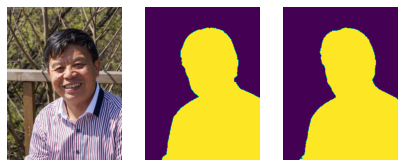

In [97]:
show_idx_image_after_train(model, test_data_loader, test_dataset, 15)

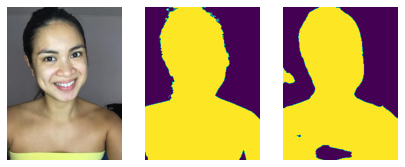

In [91]:
show_idx_image_after_train(model, test_data_loader, test_dataset, 2)

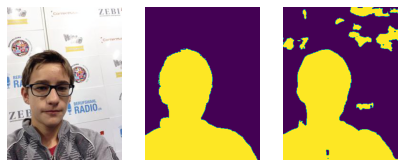

In [92]:
show_idx_image_after_train(model, test_data_loader, test_dataset, 3)

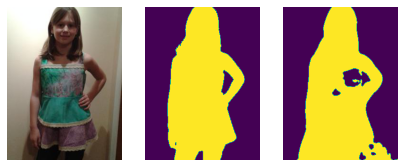

In [99]:
show_idx_image_after_train(model, test_data_loader, test_dataset, 24)

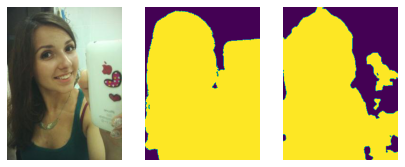

In [101]:
show_idx_image_after_train(model, test_data_loader, test_dataset,29)

На некоторых масках наша сеть дает почти идеальные формы, но есть и ошибки. Они в основном связаны с необычной позой, как на последней фотографии или же с неоднородным фотом (мальчик на фоне баннера)

Качество на тесте выше вероятно из-за того, что при обучении на трейне у нас к изображениям применяются преобразования, а картинки для теста этих изменений не имеют

## LinkNet (2 балла)## 
Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [157]:
class DecoderBlock_link(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        tmp = left + x
        #x = self.relu(self.conv1(torch.sum([left, x], 1)))###
        x = self.relu(self.conv1(tmp))###
        x = self.relu(self.conv2(x))
        return x

In [158]:
class Decoder_link(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock_link(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [159]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder_link(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [192]:
modelL = LinkNet()
if torch.cuda.is_available():
    modelL.cuda()

In [193]:
batch_size = 8
lr = 1e-5
weight_decay = 1e-4

In [194]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [195]:
criterion_L = DiceLoss(reduction='mean')
#criterion_L = torch.nn.BCEWithLogitsLoss()

optimizerL = torch.optim.Adam(modelL.parameters(), lr = lr)
#optimizerL = torch.optim.Adam(modelL.parameters(), lr = lr, weight_decay=weight_decay)

In [196]:
start_time = time.time()
DiceLoss_trainL = train(modelL, criterion_L, val_criterion, optimizerL, train_data_loader, test_data_loader, 10, device)
DiceLoss_timeL = time.time() - start_time

In [199]:
DiceLoss_timeL

918.332097530365

In [200]:
#DiceLoss_trainL[1]

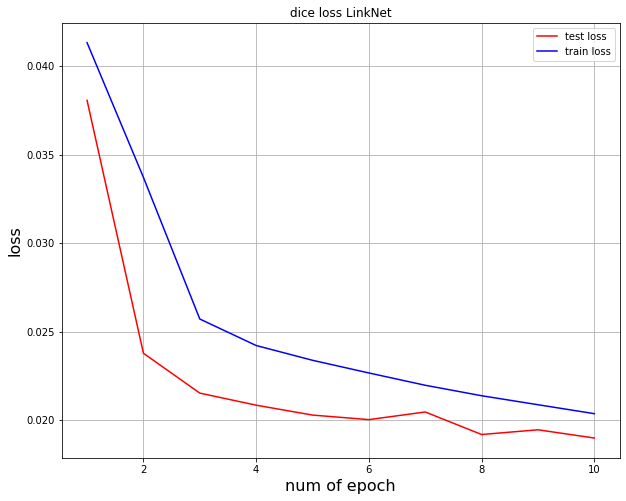

In [201]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_trainL[1][0], color = 'r', label = 'test loss')
ax.plot(epoch_n, DiceLoss_trainL[1][1], color = 'b', label = 'train loss')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('dice loss LinkNet')
plt.show()

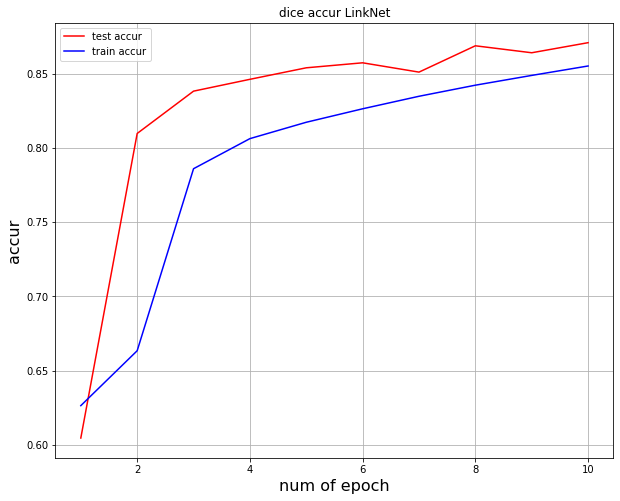

In [211]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_trainL[1][2], color = 'r', label = 'test accur')
ax.plot(epoch_n, DiceLoss_trainL[1][3], color = 'b', label = 'train accur')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('dice accur LinkNet')
plt.show()

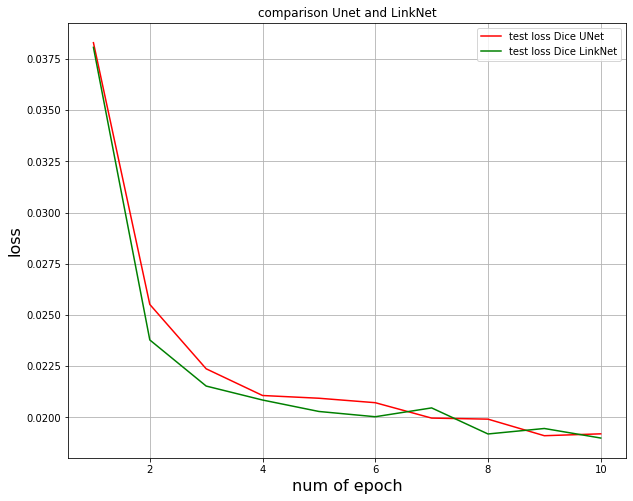

In [214]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_train[1][0], color = 'r', label = 'test loss Dice UNet')
ax.plot(epoch_n, DiceLoss_trainL[1][0], color = 'g', label = 'test loss Dice LinkNet')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison Unet and LinkNet')
plt.show()

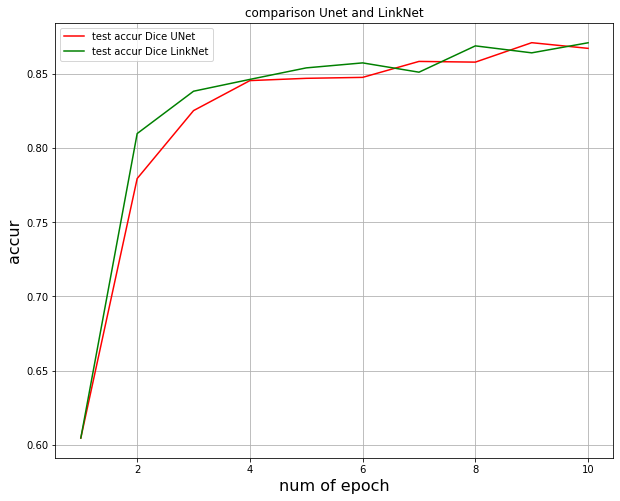

In [215]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, DiceLoss_train[1][2], color = 'r', label = 'test accur Dice UNet')
ax.plot(epoch_n, DiceLoss_trainL[1][2], color = 'g', label = 'test accur Dice LinkNet')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison Unet and LinkNet')
plt.show()

In [205]:
modelL = LinkNet()
if torch.cuda.is_available():
    modelL.cuda()

In [206]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [207]:
#criterion_L2 = DiceLoss(reduction='mean')
criterion_L2 = torch.nn.BCEWithLogitsLoss()

#optimizerL = torch.optim.Adam(modelL.parameters(), lr = lr)
optimizerL2 = torch.optim.Adam(modelL.parameters(), lr = lr, weight_decay=weight_decay)

In [208]:
start_time = time.time()
BCEWithLogitsLoss_trainL = train(modelL, criterion_L2, val_criterion, optimizerL2, train_data_loader, test_data_loader, 10, device)
BCEWithLogitsLoss_timeL = time.time() - start_time

In [209]:
BCEWithLogitsLoss_timeL

930.7340598106384

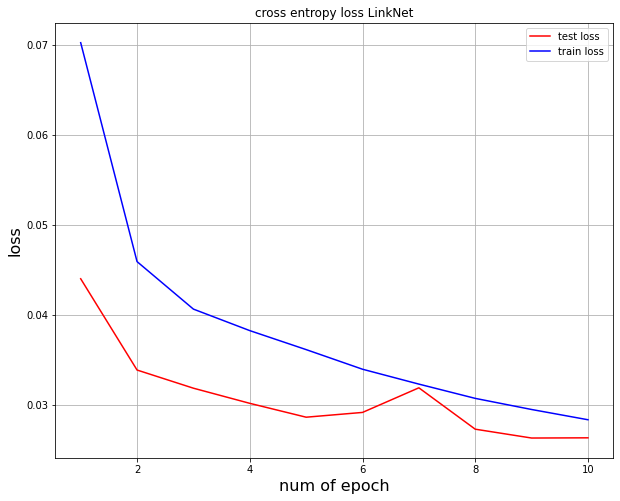

In [210]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, BCEWithLogitsLoss_trainL[1][0], color = 'r', label = 'test loss')
ax.plot(epoch_n, BCEWithLogitsLoss_trainL[1][1], color = 'b', label = 'train loss')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('cross entropy loss LinkNet')
plt.show()

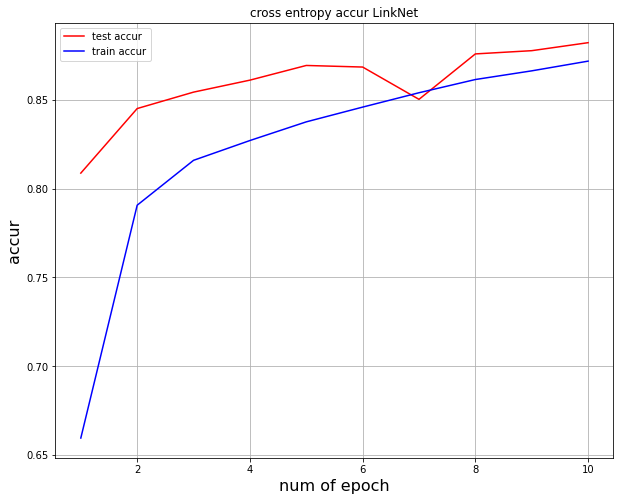

In [212]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, BCEWithLogitsLoss_trainL[1][2], color = 'r', label = 'test accur')
ax.plot(epoch_n, BCEWithLogitsLoss_trainL[1][3], color = 'b', label = 'train accur')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('cross entropy accur LinkNet')
plt.show()

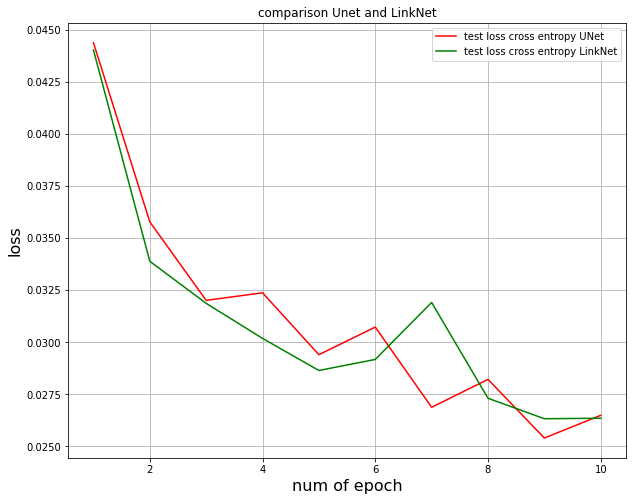

In [216]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][0], color = 'r', label = 'test loss cross entropy UNet')
ax.plot(epoch_n, BCEWithLogitsLoss_trainL[1][0], color = 'g', label = 'test loss cross entropy LinkNet')
ax.set_ylabel('loss', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison Unet and LinkNet')
plt.show()

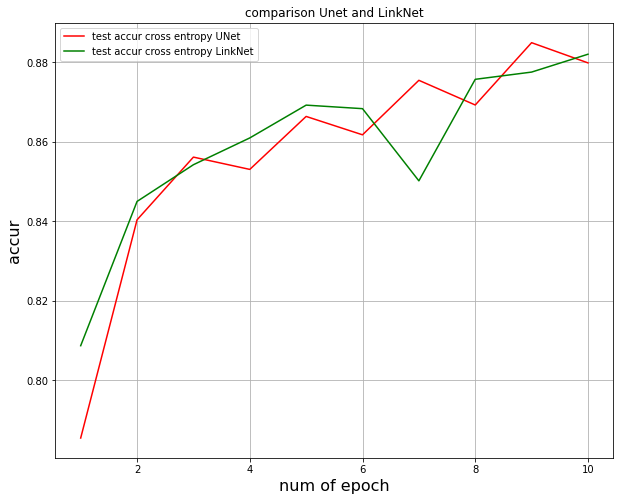

In [217]:
fig, ax = plt.subplots(figsize = (10, 8))
epoch_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.plot(epoch_n, BCEWithLogitsLoss_train[1][2], color = 'r', label = 'test accur cross entropy UNet')
ax.plot(epoch_n, BCEWithLogitsLoss_trainL[1][2], color = 'g', label = 'test accur cross entropy LinkNet')
ax.set_ylabel('accur', size = 16)
ax.set_xlabel('num of epoch', size = 16)
ax.grid()
ax.legend()
ax.set_title('comparison Unet and LinkNet')
plt.show()

**Видно, что качество обучения и потери примерно совпадают, однако время работы LinkNet меньше чем у UNet. 913 секунд против 1040, что уже существенно.**

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы.

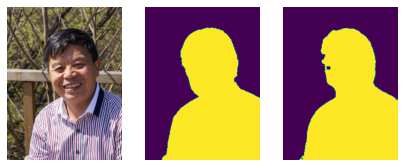

In [219]:
show_idx_image_after_train(modelL, test_data_loader, test_dataset, 15)

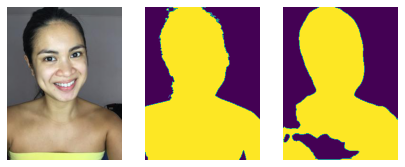

In [220]:
show_idx_image_after_train(modelL, test_data_loader, test_dataset, 2)

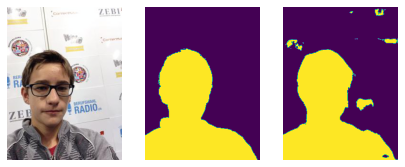

In [221]:
show_idx_image_after_train(modelL, test_data_loader, test_dataset, 3)

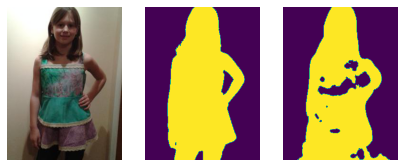

In [222]:
show_idx_image_after_train(modelL, test_data_loader, test_dataset, 24)

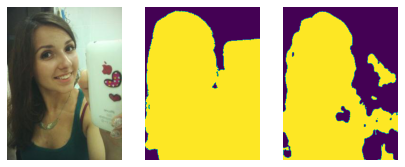

In [223]:
show_idx_image_after_train(modelL, test_data_loader, test_dataset,29)

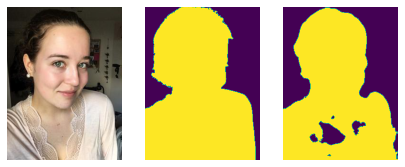

In [253]:
show_idx_image_after_train(modelL, test_data_loader, test_dataset,71)

Результаты похожи на те, что получались выше. Проблемы остальсь примерно такими же, что и у Unet'а, сложно рабоать с картинками, где сложный фон
Мне показалось, что у LinkNet больше не относящихся дырок в серединах масок. 

## Теоретические вопросы (1 балл)##

**Вопрос 1.**

* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура сверточных сетей.
* Какие преимущества дает использование сверток в случае, если эти предположения верные?
* Приведите пример входных данных, когда эти предположения не выполняются.

* при использовании сверточных нейронных сетей необходимо, чтобы выполнялись некоторые условия, а именно: локализация пиксельных зависимостей и стационарность изменений. Когда мы делаем свертки нейронных сетей мы полагаемся на эти зависимости. 
* при выполнении этих условий достигается ряд преимуществ, таких как разреженность взаимодействия и разделение весов. Мы впринципе с помощью свертки экономим параметры. 
* данные, у которых эти условия не выполняются, например определение тем текстов.

**Вопрос 2**

Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$.

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации.

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите:

1. Размерность выходного пространства.
2. Количество обучаемых параметров.
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

1) размерности будут 1000x1 для f и для g будет 10*100, потому что паддинг 1 и после свертки будет вектор длины 100. 

2) количество обучаемых параметров для f - 100 000 и для g - 30

3) число операций в первом случае будет 1000 * 100 (умножений) + 1000 * 100 (сложений) + 1000 = 200100 операций, а во втором случае, 10(карт) * (3+2) * 100 ( сто раз применить ядро) * 100( функция активации) = 50 000 000